---
# <center> **Introduction to Applied Data Science**

### <center> *Prof. Bahram Mobasher*
#### <center> Teaching Assistant: *[Sina Taamoli](https://sinataamoli.github.io/)* | email: *sina.taamoli@email.ucr.edu*
### <center> **Week 6 & 7: Naive Bayes**
---

## Naive Bayes spam filtering

Consider that you are given a data set of text messages which are labeled with ham or spam. We will use a training sample with ~4000 text messages, but first let’s consider a few examples to get familiar with the naive Bayes idea. <br>
<center>

| Class | Message | Bag of words |
| -------- | -------- | -------- |
| Spam   | Send us your password   | send, password   |
| Ham   | I will send you the letter   | send, letter   |
| Ham   | I wrote a letter   | write, letter   | <br>
</center>

We want to compute P(Spam|Bag of words). Last session, we learned from Bayes’ rule: <br>

$P(Spam | \text{Bag of words}) = \frac{P(\text{Bag of words}|Spam)P(Spam)}{P(\text{Bag of words}|Spam)P(Spam)+P(\text{Bag of words}|Ham)P(Ham)}$ <br>

P(word|spam) and P(word|ham) can be estimated from the training sample. To avoid zero probabilities, we consider the initial value of 1 for the number of occurence of a word. Note that the priors are P(ham)=2/3 and P(spam)=1/3. <br>


<center>

| Spam | Ham | Word | Spam(i=1) | Ham(i=1) |
| -------- | -------- | -------- | -------- | -------- |
| $\frac{1}{2}$   | $\frac{1}{4}$   | send   | $\frac{1+1}{2+4}$ | $\frac{1+1}{4+4}$ |
| $\frac{1}{2}$   | $\frac{0}{4}$   | password   | $\frac{1+1}{2+4}$ | $\frac{0 + 1}{4+4}$ |
$\frac{0}{2}$| $\frac{2}{4}$   | letter   | $\frac{0+1}{2+4}$   | $\frac{2+1}{4+4}$ |  |
| $\frac{0}{2}$   | $\frac{1}{4}$   | write   | $\frac{0+1}{2+4}$ | $\frac{1+1}{4+4}$ |

</center> <br>

Now, consider a new text message “write your password in the password box”. We don’t have the word “box” in our training sample, so the safe choice would be to remove this from the bag of words and make decision based on on the other two words, “write” and “password”. “password” occured twice. <br>

$P(spam|write,password,password) = \frac{P(write|spam)P(password|spam)P(password|spam)P(spam)}{P(write|Spam)P(password|Spam)P(password|spam)P(Spam)+P(write|ham)P(password|ham)P(password|ham)P(ham)}$ <br>

$P(spam|write,password,password) = \frac{\frac{1}{6} \times \frac{2}{6} \times \frac{2}{6} \times \frac{1}{3}}{\frac{1}{6} \times \frac{2}{6} \times \frac{2}{6} \times \frac{1}{3} + \frac{2}{8} \times \frac{1}{8} \times \frac{1}{8} \times \frac{2}{3}} \sim 70\%$ <br>

and $P(ham|write,password,password) = 1 − P(spam|write,password,password) = 30\%$, so we classify this email as a spam message. This was just a demonsteration of the naive Bayes method. Let’s use a large data set to build a model and evaluate its performance.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

NLTK (Natural Language Toolkit) is a set of libraries for Natural Language Processing (NLP)

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sinataamoli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Stop words are the most common words in a language which don’t carry much information. We will filter them before NLP

In [3]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [4]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

A word can have many variations with the same meaning. So, we will use stem package to normalize the words.

In [5]:
from nltk.stem import PorterStemmer
Ps = PorterStemmer()
Ps.stem('cook'), Ps.stem('cooking'), Ps.stem('cooked')

('cook', 'cook', 'cook')

We also need to remove punctuations, they are not informative in our classification.

In [6]:
import string
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Let’s load the data:

In [7]:
data = pd.read_csv('spam.csv')
data.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Change categorical data into numbers which can be processed in the code

In [8]:
data.Class

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5164    spam
5165     ham
5166     ham
5167     ham
5168     ham
Name: Class, Length: 5169, dtype: object

In [9]:
data['Class_code'] = pd.get_dummies(data.Class, drop_first=True)
data.head()

,Class,Text,Class_code
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
def train_test_split(dataframe, test_size = 0.3, rs = None):
    """
    A function which takes pandas dataframe and split it to train and test samples
    """ 
    dataframe_test = dataframe.sample(frac = test_size, random_state = rs)
    dataframe_train = dataframe.loc[dataframe.index.difference(dataframe_test.index)]
    return (dataframe_train.reset_index(drop=True), dataframe_test.reset_index(drop=True))

In [11]:
data_train, data_test = train_test_split(data, test_size = 0.3, rs = 3)

In [12]:
data_train.head()

,Class,Text,Class_code
0,ham,Ok lar... Joking wif u oni...,0
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,ham,U dun say so early hor... U c already then say...,0
3,ham,"Nah I don't think he goes to usf, he lives aro...",0
4,spam,FreeMsg Hey there darling it's been 3 week's n...,1


In [13]:
data_test.head()

,Class,Text,Class_code
0,ham,"Just looked it up and addie goes back Monday, ...",0
1,ham,You best watch what you say cause I get drunk ...,0
2,ham,Me i'm not workin. Once i get job...,0
3,ham,Yar lor... How u noe? U used dat route too?,0
4,ham,"Under the sea, there lays a rock. In the rock,...",0


Cleaning up one of the text messages as an example:

In [14]:
message = data_train.Text[46]
print(message)

Wah lucky man... Then can save money... Hee...


In [15]:
message = ''.join([x for x in message if x not in punctuations])
print(message)

Wah lucky man Then can save money Hee


In [16]:
type(message)

str

In [17]:
message.split()

['Wah', 'lucky', 'man', 'Then', 'can', 'save', 'money', 'Hee']

In [18]:
message = [x for x in message.split() if x not in stopwords]
print(message)

['Wah', 'lucky', 'man', 'Then', 'save', 'money', 'Hee']


In [19]:
message=[Ps.stem(x) for x in message]
print(message)

['wah', 'lucki', 'man', 'then', 'save', 'money', 'hee']


In [20]:
print(Counter(message))

Counter({'wah': 1, 'lucki': 1, 'man': 1, 'then': 1, 'save': 1, 'money': 1, 'hee': 1})


Now put them together in a function

In [21]:
def clean_message(message):
    """
    a function to clean up message and return a dict with bag of their occurence rate
    """
    message = message.lower()
    message = ''.join([x for x in message if x not in punctuations])
    message = [x for x in message.split() if x not in stopwords]
    message=[Ps.stem(x) for x in message]
    
    return (Counter(message))

In [22]:
print(data_train.Text[10])
print(clean_message(data_train.Text[10]))

I HAVE A DATE ON SUNDAY WITH WILL!!
Counter({'date': 1, 'sunday': 1})


Apply the function to all the data set

In [23]:
data_train['bag_of_words'] = data_train['Text'].apply(clean_message)
data_train.head()

,Class,Text,Class_code,bag_of_words
0,ham,Ok lar... Joking wif u oni...,0,"{'ok': 1, 'lar': 1, 'joke': 1, 'wif': 1, 'u': ..."
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,"{'free': 1, 'entri': 2, '2': 1, 'wkli': 1, 'co..."
2,ham,U dun say so early hor... U c already then say...,0,"{'u': 2, 'dun': 1, 'say': 2, 'earli': 1, 'hor'..."
3,ham,"Nah I don't think he goes to usf, he lives aro...",0,"{'nah': 1, 'dont': 1, 'think': 1, 'goe': 1, 'u..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...,1,"{'freemsg': 1, 'hey': 1, 'darl': 1, '3': 1, 'w..."


In [24]:
bows = data_train.bag_of_words
bows

0       {'ok': 1, 'lar': 1, 'joke': 1, 'wif': 1, 'u': ...
1       {'free': 1, 'entri': 2, '2': 1, 'wkli': 1, 'co...
2       {'u': 2, 'dun': 1, 'say': 2, 'earli': 1, 'hor'...
3       {'nah': 1, 'dont': 1, 'think': 1, 'goe': 1, 'u...
4       {'freemsg': 1, 'hey': 1, 'darl': 1, '3': 1, 'w...
                              ...                        
3613    {'2nd': 1, 'time': 1, 'tri': 1, '2': 2, 'conta...
3614    {'ì': 1, 'b': 1, 'go': 1, 'esplanad': 1, 'fr':...
3615     {'piti': 1, 'mood': 1, 'soani': 1, 'suggest': 1}
3616    {'guy': 1, 'bitch': 1, 'act': 1, 'like': 1, 'i...
3617                    {'rofl': 1, 'true': 1, 'name': 1}
Name: bag_of_words, Length: 3618, dtype: object

In [25]:
bows_ham = data_train[data_train.Class_code == 0].bag_of_words
bows_spam = data_train[data_train.Class_code == 1].bag_of_words

In [26]:
bows_spam

1       {'free': 1, 'entri': 2, '2': 1, 'wkli': 1, 'co...
4       {'freemsg': 1, 'hey': 1, 'darl': 1, '3': 1, 'w...
7       {'six': 1, 'chanc': 1, 'win': 1, 'cash': 1, '1...
8       {'urgent': 1, '1': 1, 'week': 1, 'free': 1, 'm...
16      {'thank': 1, 'subscript': 1, 'rington': 1, 'uk...
                              ...                        
3587    {'privat': 1, '2003': 1, 'account': 1, 'statem...
3593    {'ask': 1, '3mobil': 1, '0870': 1, 'chatlin': ...
3600    {'contract': 1, 'mobil': 1, '11': 1, 'mnth': 1...
3612    {'remind': 1, 'o2': 1, 'get': 1, '250': 1, 'po...
3613    {'2nd': 1, 'time': 1, 'tri': 1, '2': 2, 'conta...
Name: bag_of_words, Length: 436, dtype: object

In [27]:
words = list(set().union(*bows))
words

['natalja',
 'surrend',
 'genu',
 '88039',
 'deni',
 'unicef',
 'statu',
 'hun',
 'habit',
 'ammaelif',
 'fun',
 'anderson',
 '36504',
 'came',
 'vewi',
 'aka',
 'suntec',
 'man',
 'mobstorequiz10ppm',
 'pobox36504w45wq',
 'match',
 'snicker',
 'moneeppolum',
 'elabor',
 'bright',
 'want',
 'dhort',
 '731',
 'wwwdbuknet',
 '8am',
 'ac',
 'holidayso',
 'restwish',
 'mistakeu',
 'k',
 'wake',
 'cameravideo',
 'morningtak',
 'later',
 'ringtoneget',
 'anti',
 'wwwclubmobycom',
 'ralph',
 'foward',
 'reappli',
 'behalf',
 'write',
 'sankranti',
 'capac',
 'eta',
 'lo',
 'boytoy',
 'transfr',
 'nothin',
 'alett',
 'vodafon',
 'taken',
 'webeburnin',
 'eaten',
 '09061701851',
 'thrown',
 'tkt',
 'newsbi',
 'old',
 'exercis',
 'sparkl',
 'hillsborough',
 'outfor',
 'would',
 'strong',
 'doggin',
 'simonwatson5120',
 'itjust',
 'aiyo',
 'kickbox',
 'jame',
 'kwish',
 'belli',
 'independ',
 'athlet',
 'affect',
 'rhode',
 'weed',
 'serena',
 'carpark',
 'heard',
 'instantli',
 'rael',
 'switch'

In [28]:
len(words)

6412

In [29]:
number_of_occurence_ham = {key:1 for key in words} # Initializing all words by occurance=1
for word in words:
    for bow in bows_ham:
        if word in bow.keys():
            number_of_occurence_ham[word] += bow[word]

In [30]:
number_of_occurence_ham['soon']

35

In [32]:
number_of_occurence_spam={key:1 for key in words}
for word in words:
    for bow in bows_spam:
        if word in bows.keys():
            number_of_occurence_spam[word] += bow[word]

In [33]:
number_of_occurence_spam['free']

1

Probability of a word given that the text is ham/spam

In [34]:
number_of_occurence_ham

{'natalja': 1,
 'surrend': 2,
 'genu': 2,
 '88039': 1,
 'deni': 4,
 'unicef': 1,
 'statu': 3,
 'hun': 2,
 'habit': 2,
 'ammaelif': 2,
 'fun': 15,
 'anderson': 2,
 '36504': 1,
 'came': 15,
 'vewi': 3,
 'aka': 3,
 'suntec': 3,
 'man': 24,
 'mobstorequiz10ppm': 1,
 'pobox36504w45wq': 1,
 'match': 6,
 'snicker': 2,
 'moneeppolum': 2,
 'elabor': 2,
 'bright': 3,
 'want': 156,
 'dhort': 2,
 '731': 1,
 'wwwdbuknet': 1,
 '8am': 3,
 'ac': 1,
 'holidayso': 2,
 'restwish': 2,
 'mistakeu': 2,
 'k': 47,
 'wake': 23,
 'cameravideo': 1,
 'morningtak': 2,
 'later': 81,
 'ringtoneget': 1,
 'anti': 2,
 'wwwclubmobycom': 1,
 'ralph': 2,
 'foward': 2,
 'reappli': 2,
 'behalf': 2,
 'write': 5,
 'sankranti': 2,
 'capac': 2,
 'eta': 3,
 'lo': 2,
 'boytoy': 13,
 'transfr': 2,
 'nothin': 2,
 'alett': 2,
 'vodafon': 1,
 'taken': 2,
 'webeburnin': 1,
 'eaten': 4,
 '09061701851': 1,
 'thrown': 2,
 'tkt': 1,
 'newsbi': 2,
 'old': 13,
 'exercis': 2,
 'sparkl': 1,
 'hillsborough': 2,
 'outfor': 2,
 'would': 52,
 'st

In [36]:
P_word_h={}
P_word_s={}
for key in number_of_occurence_ham:
    P_word_h[key] = number_of_occurence_ham[key] / sum(number_of_occurence_ham.values())
    
for key in number_of_occurence_spam:
    P_word_s[key] = number_of_occurence_spam[key] / sum(number_of_occurence_spam.values())

Finding the priors

In [37]:
P_h = bows_ham.size / bows.size 
P_s = bows_spam.size / bows.size

In [38]:
print(P_s)
print(P_h)

0.1205085682697623
0.8794914317302377


In [39]:
def classifier(document):
    document_bag_of_words = clean_message(document)
    P_document_h = 1
    P_document_s = 1
    for key in document_bag_of_words:
        if key in words:
            P_document_h = P_document_h * P_word_h[key]
            P_document_s = P_document_s * P_word_s[key]
            
    P_document_h = P_document_h * P_h
    P_document_s = P_document_s * P_s
    
    Pr_doc_h_normalized = P_document_h / (P_document_h + P_document_s)
    
    if Pr_doc_h_normalized > 0.5:
        return 0
    else:
        return 1
    
classifier=np.vectorize(classifier)

In [40]:
classifier('congratulations! you won $500')

array(1)

In [41]:
classifier("Let's apply this model to the test sample")

array(0)

In [42]:
prediction = classifier(data_test.Text.values)

In [43]:
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
T = data_test.Class_code
T

0       0
1       0
2       0
3       0
4       0
       ..
1546    1
1547    0
1548    0
1549    0
1550    0
Name: Class_code, Length: 1551, dtype: uint8

In [45]:
TP, TN, FP, FN = 0, 0, 0, 0
for i in range(len(T)):
    if T[i] == 1:
        if prediction[i] == 1:
            TP += 1
            
        if prediction[i] == 0:
            FN += 1
    
    if T[i] == 0:
        if prediction[i] == 1:
            FP += 1
        if prediction[i] == 0:
            TN += 1

Confusion matrix

In [46]:
print(np.array([[TP,FP],[FN,TN]]))

[[  41    5]
 [ 176 1329]]


In [47]:
precision=TP/(TP+FP)
print("precision=",precision)

precision= 0.8913043478260869


In [49]:
recall=TP/(TP+FN)
print("recall=",recall)

recall= 0.1889400921658986


In [50]:
F1_score=2*precision*recall/(precision+recall)
print("F1_score=",F1_score)

F1_score= 0.31178707224334595


In [48]:
accuracy=(TP+TN)/(TP+FP+FN+TN)
print("accuracy=",accuracy)

accuracy= 0.8833010960670535


# Homework 2 Solution

### Problem 1a. Read file and calculate tweets and

### Problem 1b.  Use matplotlib.pyplot.bar to create figure

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.pyplot import figure

def Import_Data(file):
    # [0] = array pos; [1] = week # ; [2] = tweet count
    data = pd.read_csv(file)
    
    #Convert to array
    npData = data.to_numpy()
    
    #print(npData)
    return(npData)
    
def SortData(file):
    week = np.empty(0) #pos 0
    count = np.empty(0) #pos 1
    num = 0
    data = Import_Data(file)  #Import data from csv, convert, and return
    for i in data:
        week = np.append(week, i[0])
        count = np.append(count, i[1])
    return week, count

In [53]:
SortData('tweet_counts-1.csv')

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.]),
 array([39., 46., 41., 42., 31., 44., 33., 42., 31., 28., 36., 40., 33.,
        45., 42., 28., 34., 42., 45., 37., 39., 35., 28., 30., 24., 40.,
        22., 46., 37., 37., 38., 36., 41., 38., 42., 43., 30., 45., 46.,
        51., 55., 36., 42., 44., 36., 44., 41., 38., 38., 56., 39., 40.]))

In [54]:
def PlotData(function, file): #takes output week, count from sort data and plots as x, y
    x_val, y_val = function(file) #week, count returned
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (10,2.5)
                 
    #Set tick mark position
    ax.tick_params(bottom=True, top=True, left=True, right=True)
    ax.tick_params(which="minor", bottom=False, top=True, left=True, right=True)
    ax.tick_params(which="major", axis="x", direction="in")
    ax.tick_params(which="minor", axis="x", direction="in")
    
    #Set axis limits
    ax.set_xlim(0, max(x_val)+2, 10)
    ax.set_ylim(0, max(y_val)+1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_ticks(np.arange(4, max(x_val)+1, 4))
    
    #Plot labels
    plt.xlabel("Week")
    plt.ylabel("Number of tweets")
    plt.title("Problem 1b: Avg # of weekly tweets over last year")
    
    # Add data
    ax.bar(x_val, y_val, color ='steelblue', edgecolor = "black", width = 0.8)
    ax.hlines(y=np.average(y_val), xmin=0, xmax=max(x_val)+2, linewidth=2, color='r', linestyle='dashed', alpha=0.5)

[39. 46. 41. 42. 31. 44. 33. 42. 31. 28. 36. 40. 33. 45. 42. 28. 34. 42.
 45. 37. 39. 35. 28. 30. 24. 40. 22. 46. 37. 37. 38. 36. 41. 38. 42. 43.
 30. 45. 46. 51. 55. 36. 42. 44. 36. 44. 41. 38. 38. 56. 39. 40.]
Average tweets per week: 38.77


<ipython-input-54-c570711fdc41>:13: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_xlim(0, max(x_val)+2, 10)


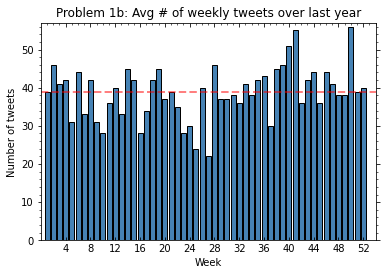

In [55]:
weeks, tweets = SortData('tweet_counts-1.csv')
print(tweets)
avg = np.average(tweets)
print("Average tweets per week: %.2f" %avg) #pos 1 is counts

PlotData(SortData,'tweet_counts-1.csv')

# Problem 1d. Plot P(λ) vs λ

In [56]:
import math
import matplotlib.pyplot as plt

def CalcExpon(lambda_, alpha):
    pLam = alpha * math.exp(-1 * lambda_ * alpha) # e^(−λ)
    return pLam

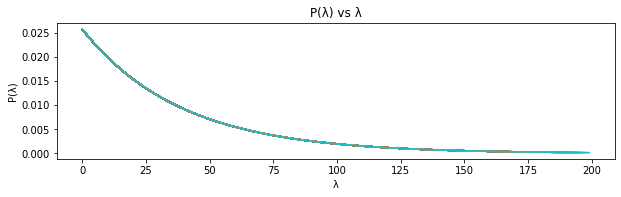

In [57]:
fig, ax = plt.subplots()
plt.title("P(λ) vs λ")
ax.set_xlabel("λ")
ax.set_ylabel("P(λ)")
weeks, tweets = SortData('tweet_counts-1.csv')

expon = np.empty(0)
lambda_vals = np.empty(0)
mean = np.average(tweets)

for i in range(0, 200, 1):
    alpha = 1/mean
    if(i == 0):
        i = 0.0001
    expon = np.append(expon, CalcExpon(i, alpha))
    lambda_vals = np.append(lambda_vals, i)
    ax.plot(lambda_vals, expon)
plt.show()

# Problem 1e.  Use numpy.linspace to create two variables with 1×50 array in the interval of 25 and 50.

### See rationale on .pdf document

In [58]:
def MakeMesh():
    weeks, tweets = SortData('tweet_counts-1.csv')
    lam1 = np.linspace(25, 50, 50)
    lam2 = np.linspace(25, 50, 50)
    z = weeks
    mean = np.average(tweets)
    alpha = 1/mean
    
    L1, L2, Wk = np.meshgrid(lam1, lam2, z) #returns meshgrid
    return L1, L2, Wk

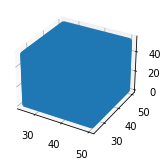

In [59]:
L1, L2, Wk = MakeMesh()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(L1, L2, Wk)
L1.shape
plt.show()

## Problem 1f. Find marginalized-posterior for λ1, λ2 and Ws

## Plot posteriors for λ1 and λ2.

In [61]:
def CalcFactorial(k):
    count = k
    fact = 1
    while(count > 0):
        fact = fact * count      
        count -= 1
    return(fact)

def CalcLikely(lambda_, k): #lambda start = set mean, k = current set position
    # likelihood P(x|θ): is PDF of Poisson distribution: (λ^k/k!) e^(−λ) Where lambda is avg val
    lambda_exponK = lambda_**k # λ^k\n
    
    k_fact = CalcFactorial(k) # k!
    
    e_negLambda = math.exp(lambda_ * -1) # e^(−λ)
    
    prob = (lambda_exponK/k_fact) * e_negLambda  # (λ^k/k!) e^(−λ)
    
    return prob

def CalcPrior(lambda_):
    alpha = 1/lambda_
    #Prior P(θ): starting value of λ is avg val across all weeks, approx 38.8
    prior = alpha * math.exp(-1 * lambda_ * alpha)
    
    return prior

def CalcPoster(lambda_, k, prior):
    #calc likelihood
    likelihood = CalcLikely(lambda_, k) #(λ^k/k!) e^(−λ)
    
    #calc new posterior
    posterior = likelihood * prior
    
    return posterior,likelihood, prior

In [62]:
def FindPosterior():
    weeks, tweets = SortData('tweet_counts-1.csv')
    highestPost = 0
    ws = 1/52
    
    L1, L2, Wk = MakeMesh() #returns meshgrid and figure
    priorW = CalcPrior(ws)
    lam1probVals = np.empty(0)
    lam2probVals = np.empty(0)
    weekVals = np.empty(0)
    normalized = 0
    
    #Get mext L2 value
    for l2 in range(0, 50, 1):
        lam2 = L2[l2][0][0]
        prior2 = CalcPrior(lam2)
        
        #Get nextL1 value
        for l1 in range(0, 50, 1):
            lam1 = L1[0][l1][0]
            prior1 = CalcPrior(lam1)
            
            for z in range(0, 52, 1):  #Check next week position as Ws
                poster = prior1 * prior2 * priorW  #calc and mult (Pλ1)(Pλ2)(Ws)
                weekTest = int(Wk[0][0][z])  #Set poss Ws
                
                for i in range(0, 52, 1):
                    tweetWeek = weeks[i]
                    tweetCount = tweets[i]
                
                    if(tweetWeek < weekTest): #Week before Ws being tested
                        likely = CalcLikely(lam1, tweetCount)
                    else:
                        likely = CalcLikely(lam2, tweetCount)
                                          
                    poster = poster * likely
                
                if(poster > highestPost):
                    highestPost = poster
                    maxLam1 = lam1
                    maxLam2 = lam2
                    maxWeek = weekTest
            
                       
    print("Max Posterior value: ", highestPost)
    print("Max Lam1 value: ", maxLam1)
    print("Max Lam2 value: ", maxLam2)
    print("Week Ws: ", maxWeek)

    return(highestPost, maxLam1, maxLam2, maxWeek)
                
FindPosterior()

Max Posterior value:  7.038290456198644e-77
Max Lam1 value:  36.734693877551024
Max Lam2 value:  43.36734693877551
Week Ws:  38


(7.038290456198644e-77, 36.734693877551024, 43.36734693877551, 38)

Max Posterior value:  7.038290456198644e-77
Max Lam1 value:  36.734693877551024
Max Lam2 value:  43.36734693877551
Week Ws:  38


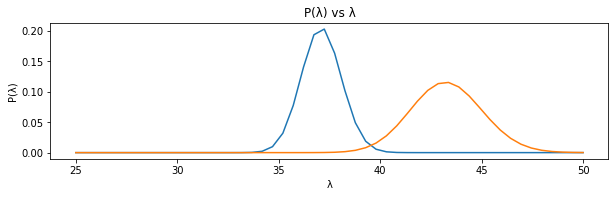

(array([25.        , 25.51020408, 26.02040816, 26.53061224, 27.04081633,
        27.55102041, 28.06122449, 28.57142857, 29.08163265, 29.59183673,
        30.10204082, 30.6122449 , 31.12244898, 31.63265306, 32.14285714,
        32.65306122, 33.16326531, 33.67346939, 34.18367347, 34.69387755,
        35.20408163, 35.71428571, 36.2244898 , 36.73469388, 37.24489796,
        37.75510204, 38.26530612, 38.7755102 , 39.28571429, 39.79591837,
        40.30612245, 40.81632653, 41.32653061, 41.83673469, 42.34693878,
        42.85714286, 43.36734694, 43.87755102, 44.3877551 , 44.89795918,
        45.40816327, 45.91836735, 46.42857143, 46.93877551, 47.44897959,
        47.95918367, 48.46938776, 48.97959184, 49.48979592, 50.        ]),
 array([2.74490029e-118, 2.40431223e-114, 1.19849940e-110, 3.47516815e-107,
        5.98370055e-104, 6.23852784e-101, 4.01152005e-098, 1.61887928e-095,
        4.16831948e-093, 6.95564211e-091, 7.63455352e-089, 5.59005362e-087,
        2.76723891e-085, 9.38003743e-084

In [63]:
def FindLambdas():
    weeks, tweets = SortData('tweet_counts-1.csv')
    lam1Vals = np.empty(0)
    lam1Probs = np.empty(0)
    lam2Vals = np.empty(0)
    lam2Probs = np.empty(0)
    
    L1, L2, Wk = MakeMesh() #returns meshgrid and figure
    #get first L1 prior value
    
    highestPost, lam1, lam2, maxWk = FindPosterior()
    
    lam1orig = lam1
    #Set lam 2, W as constants
    prior1 = CalcPrior(lam1)
    prior2 = CalcPrior(lam2)
    priorW = CalcPrior(maxWk)
    
    weekTest = priorW  #Set poss Ws
        
    for l1 in range(0, 50, 1):    
        lam1 = L1[0][l1][0]
        poster = CalcPrior(lam1)

        for i in range(0, 52, 1):
            tweetCount = tweets[i]
            if(i >= maxWk):
                poster = poster * CalcLikely(lam2, tweets[i])
            else:
                poster = poster * CalcLikely(lam1, tweets[i])
                
        lam1Vals = np.append(lam1Vals, lam1)
        lam1Probs = np.append(lam1Probs, poster)
    
    lam1 = lam1orig  #Reset lam1 val before lam2 calc usage
    
    for l2 in range(0, 50, 1):  
         
        lam2 = L2[l2][0][0]
        poster = CalcPrior(lam2)
        
        for i in range(38, 52, 1):
            tweetCount = tweets[i]
            if(i >= maxWk):
                poster = poster * CalcLikely(lam2, tweets[i])
            else:
                poster = poster * CalcLikely(lam1, tweets[i])
                
            prior2 = poster
        
        lam2Vals = np.append(lam2Vals, lam2)
        lam2Probs = np.append(lam2Probs, poster)
    
    fig, ax = plt.subplots()

    plt.title("P(λ) vs λ")
    ax.set_xlabel("λ")
    ax.set_ylabel("P(λ)")

    ax.plot(lam1Vals, lam1Probs/sum(lam1Probs)) #normalized values
    ax.plot(lam2Vals, lam2Probs/sum(lam2Probs)) #normalized values
    plt.show()  
    
    return lam1Vals, lam1Probs, lam2Vals, lam2Probs  
                
FindLambdas()

## Create a bar plot for posterior of Ws in a separate figure

Max Posterior value:  7.038290456198644e-77
Max Lam1 value:  36.734693877551024
Max Lam2 value:  43.36734693877551
Week Ws:  38


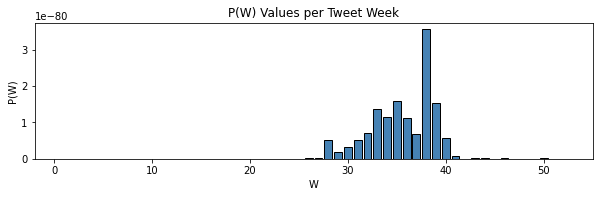

In [64]:
def FindW():
    #returns highestPost, maxLam1, maxLam2, maxWeek)
    hiPost, lam1, lam2, maxWk = FindPosterior()
    weeks, tweets = SortData('tweet_counts-1.csv')
    lam1probVals = np.empty(0)
    lam2probVals = np.empty(0)
    weekVals = np.empty(0)
    
    #Set lam 2, W as constants
    prior1 = CalcPrior(lam1)
    prior2 = CalcPrior(lam2)
    priorW = CalcPrior(maxWk)
    
    #Get next W value
    for z in range(0, 52, 1):  #Check next week position as Ws
        poster = prior1 * prior2 * priorW  #calc and mult (Pλ1)(Pλ2)(Ws)
        weekTest = int(Wk[0][0][z])  #Set poss Ws
        
        for i in range(0, 52, 1):
            tweetWeek = weeks[i]
            tweetCount = tweets[i]
            
            if(tweetWeek < weekTest): 
                likely = CalcLikely(lam1, tweetCount)
            else:
                likely = CalcLikely(lam2, tweetCount)
            poster = poster * likely
        weekVals = np.append(weekVals, poster)
    
    fig, ax = plt.subplots()
     
    #Plot labels
    plt.xlabel("W")
    plt.ylabel("P(W)")
    plt.title("P(W) Values per Tweet Week")
    
    # Add data
    ax.bar(weeks, weekVals, color ='steelblue', edgecolor = "black", width = 0.8)

FindW()

## Problem 1g. Use marginalized 2-D posteriors of λ1 and λ2 to obtain P(λ2 −λ1 > 5)

Max Posterior value:  7.038290456198644e-77
Max Lam1 value:  36.734693877551024
Max Lam2 value:  43.36734693877551
Week Ws:  38


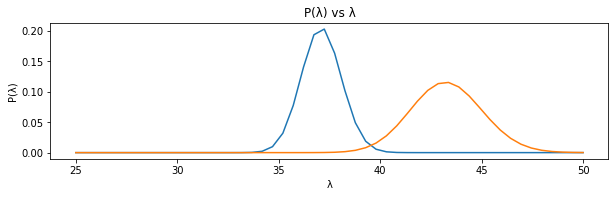

P2 - P1 > 5:  38.714088475445


In [65]:
def DeltaLambda():
    lam1Vals, lam1Probs, lam2Vals, lam2Probs = FindLambdas()
    normal = lam1Probs/sum(lam1Probs)
    sumGreater5 = 0
    
    normal2 = lam2Probs/sum(lam2Probs)
    
    for i in range(0, 50, 1):
        p1 = normal[i]  #normalized lambda 1 values
        for j in range (0, 50, 1):
            p2 = normal[j]  #normalized lambda 2 values
            deltaPs = p2 - p1
            if((deltaPs) > .05):
                sumGreater5 += deltaPs
    print("P2 - P1 > 5: ", sumGreater5)
    return               
DeltaLambda()